## Loading the Dataset


In [1]:
################# Load the Dataset###################
#####################################################

import pandas as pd

# File paths: Modify the path as per your dataset location
file_path = '/content/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'

# Load the dataset using pandas
try:
    data = pd.read_csv(file_path)
    print("Dataset successfully loaded!")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please check if the file path is correct.")

# Display basic information about the dataset
print("\nDataset Information:")
print(data.info())  # Shows column types and non-null counts

print("\nFirst 5 Rows of the Dataset:")
print(data.head())  # Displays the first 5 rows of the dataset to get an initial feel

# Check for missing values in the dataset
print("\nMissing Values in Each Column:")
print(data.isnull().sum())  # Summarizes missing values for each column

# Dataset size (rows and columns)
print("\nDataset Size (rows, columns):")
print(data.shape)


Dataset successfully loaded!

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64 

## Import Libraries

In [ ]:
################ Importing necessary libraries #######################
######################################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import gym
import tensorflow as tf
from tensorflow.keras import models, layers
import random
from collections import deque


## Load Data and Initial Preprocessing

In [ ]:
################### Load and Preprocess the Data #######################
########################################################################

# Assuming 'data' is the DataFrame loaded from CSV
# data = pd.read_csv('path_to_your_dataset.csv')  # Uncomment to load your dataset

# Verify the initial columns
print("Initial Columns:", data.columns)

# Strip leading/trailing whitespaces from column names
data.columns = data.columns.str.strip()

# Drop irrelevant columns
columns_to_drop = ['Flow ID', 'Source IP', 'Destination IP', 'Timestamp']
data = data.drop(columns=columns_to_drop, inplace=False)
print(f"Dropped columns: {columns_to_drop}")

# Drop rows where 'Label' is missing
data = data.dropna(subset=['Label'])
print("Remaining Columns:", data.columns)


Initial Columns: Index(['Flow ID', ' Source IP', ' Source Port', ' Destination IP',
       ' Destination Port', ' Protocol', ' Timestamp', ' Flow Duration',
       ' Total Fwd Packets', ' Total Backward Packets',
       'Total Length of Fwd Packets', ' Total Length of Bwd Packets',
       ' Fwd Packet Length Max', ' Fwd Packet Length Min',
       ' Fwd Packet Length Mean', ' Fwd Packet Length Std',
       'Bwd Packet Length Max', ' Bwd Packet Length Min',
       ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s',
       ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max',
       ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std',
       ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean',
       ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags',
       ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags',
       ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s',
       ' Bwd Packets/s', ' Min Packet 

## Label Encoding

In [ ]:
############# Initialize LabelEncoder and encode 'Label' column ######
######################################################################

le = LabelEncoder()
data['Label'] = le.fit_transform(data['Label'])

# Verify the encoding
print("Unique values in 'Label' after encoding:", data['Label'].unique())

# Print the label mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Encoding Mapping:", label_mapping)


Unique values in 'Label' after encoding: [0 1]
Label Encoding Mapping: {'BENIGN': 0, 'DDoS': 1}


## Handling Missing and Infinite Values

In [ ]:
##### Identify numerical columns (excluding 'Label') #########
##############################################################

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols.remove('Label')  # Don't scale the 'Label' column

# Check for infinite values in numerical columns
infinite_cols = data[numerical_cols].columns[np.isinf(data[numerical_cols]).any()].tolist()
print(f"Columns with infinite values: {infinite_cols}")

# Replace infinite values with the maximum finite value of that column
for col in infinite_cols:
    max_value = data[np.isfinite(data[col])][col].max()
    data[col].replace([np.inf, -np.inf], max_value, inplace=True)
    print(f"Replaced infinite values in '{col}' with {max_value}")


Columns with infinite values: ['Flow Bytes/s', 'Flow Packets/s']
Replaced infinite values in 'Flow Bytes/s' with 2070000000.0
Replaced infinite values in 'Flow Packets/s' with 3000000.0


<ipython-input-8-af326219702f>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].replace([np.inf, -np.inf], max_value, inplace=True)


##  Standard Scaling

In [ ]:
################### Initialize the StandardScaler and scale the numerical columns ###########
#############################################################################################

scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Verify scaling
print("\nFirst 5 rows of the scaled dataset:")
print(data.head())

# Confirm that the mean is approximately 0 and std is approximately 1 for each feature
scaled_summary = data[numerical_cols].describe().T[['mean', 'std']]
print("\nSummary statistics for scaled features (mean should be close to 0, std close to 1):")
print(scaled_summary)



First 5 rows of the scaled dataset:
   Source Port  Destination Port  Protocol  Flow Duration  Total Fwd Packets  \
0    -1.640029          2.327831 -0.412278      -0.515210          -0.186406   
1    -1.655773          2.337398 -0.412278      -0.515207          -0.251245   
2    -1.655773          2.337449 -0.412278      -0.515209          -0.251245   
3    -1.640029          1.891022 -0.412278      -0.515209          -0.251245   
4    -1.640029          2.327730 -0.412278      -0.515210          -0.186406   

   Total Backward Packets  Total Length of Fwd Packets  \
0               -0.210191                    -0.285426   
1               -0.164225                    -0.287273   
2               -0.164225                    -0.287273   
3               -0.164225                    -0.287273   
4               -0.210191                    -0.285426   

   Total Length of Bwd Packets  Fwd Packet Length Max  Fwd Packet Length Min  \
0                    -0.151982              -0.285676

## Train-Test Split

In [ ]:
############### Split the data into training and testing sets #########
#######################################################################

X = data.drop('Label', axis=1)  # Features
y = data['Label']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (180596, 80)
Testing data shape: (45149, 80)


## Define Custom Gym Environment for DDoS Detection

In [ ]:
##### Define a custom Gym environment for DDoS detection ###
############################################################

class DDoSEnv(gym.Env):
    def __init__(self, X, y):
        super(DDoSEnv, self).__init__()
        self.observation_space = gym.spaces.Box(low=-np.inf, high=np.inf, shape=(X.shape[1],))
        self.action_space = gym.spaces.Discrete(2)  # Two actions: 0 (Normal), 1 (DDoS)
        self.X = X
        self.y = y
        self.current_step = 0

    def reset(self):
        self.current_step = 0
        return self.X[self.current_step]

    def step(self, action):
        correct_label = self.y[self.current_step]
        reward = 1 if action == correct_label else -1
        done = (self.current_step == len(self.X) - 1)
        self.current_step += 1
        return self.X[self.current_step], reward, done, {}

# Instantiate the environment
env = DDoSEnv(X_train.values, y_train.values)


## Build the DQN Agent

In [ ]:
######### Build the DQN Agent for reinforcement learning #######
################################################################

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # Discount rate
        self.epsilon = 1.0   # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        model = models.Sequential()
        model.add(layers.Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(layers.Dense(24, activation='relu'))
        model.add(layers.Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Instantiate the DQN agent
state_size = X_train.shape[1]
action_size = 2  # Two actions (Normal, DDoS)
agent = DQNAgent(state_size, action_size)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Training the DQN Agent

In [ ]:
# # Training the DQN Agent
# num_episodes = 1000  # Number of episodes to train the agent
# batch_size = 32  # Size of the minibatch for training

# for e in range(num_episodes):
#     # Reset the environment at the beginning of each episode
#     state = env.reset()
#     state = np.reshape(state, [1, state_size])
#     total_reward = 0

#     for time in range(len(X_train)):  # Go through all steps in the training data
#         # The agent takes an action
#         action = agent.act(state)

#         # Get the next state, reward, and whether the episode is done
#         next_state, reward, done, _ = env.step(action)
#         next_state = np.reshape(next_state, [1, state_size])

#         # Remember the experience
#         agent.remember(state, action, reward, next_state, done)

#         # Move to the next state
#         state = next_state

#         total_reward += reward

#         if done:
#             print(f"Episode: {e}/{num_episodes}, Time: {time}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2}")
#             break

#         # Train the agent with the experiences of the episode
#         if len(agent.memory) > batch_size:
#             agent.replay(batch_size)


In [ ]:
##### Use a subset of the data for quick testing ########

X_train_small = X_train[:500]  # First 500 samples for training
y_train_small = y_train[:500]

# Recreate environment with smaller dataset
env = DDoSEnv(X_train_small.values, y_train_small.values)

# Hyperparameters
episodes = 10  # Reduced number of episodes
batch_size = 16  # Smaller batch size

for e in range(episodes):
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(100):  # Limit steps per episode to 100
        action = agent.act(state)  # Agent takes action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Remember the experience
        agent.remember(state, action, reward, next_state, done)

        # Update state
        state = next_state

        if done:
            print(f"Episode {e+1}/{episodes} - Score: {time}, Epsilon: {agent.epsilon}")
            break

    # Train the agent with experience replay
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

print("Training completed.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━

## Testing Function

In [ ]:
###### Test the DQN Agent on the test set ######################
################################################################

def test_dqn_agent(agent, env, X_test, y_test):
    """
    Function to test the performance of the trained DQN agent on the test set.
    """
    # Recreate the environment using the test set
    env_test = DDoSEnv(X_test.values, y_test.values)

    total_rewards = 0
    total_steps = 0
    correct_predictions = 0

    state = env_test.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(len(X_test) - 1):  # Ensure we don't go out of bounds
        action = agent.act(state)  # Agent predicts action based on state
        next_state, reward, done, _ = env_test.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        total_rewards += reward
        total_steps += 1

        # Count correct predictions
        if reward == 1:
            correct_predictions += 1

        # Update state
        state = next_state

        if done:  # If done, break from the loop early
            break

    accuracy = correct_predictions / total_steps if total_steps > 0 else 0
    print(f"Test Results - Accuracy: {accuracy * 100:.2f}%")
    print(f"Total Rewards: {total_rewards}")
    print(f"Total Steps: {total_steps}")

    return accuracy, total_rewards

# Testing the trained agent on the test dataset
X_test_small = X_test[:500]  # For quick testing on small test set
y_test_small = y_test[:500]

# Test the agent
accuracy, total_rewards = test_dqn_agent(agent, env, X_test_small, y_test_small)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

## Plot Learning Progress

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━

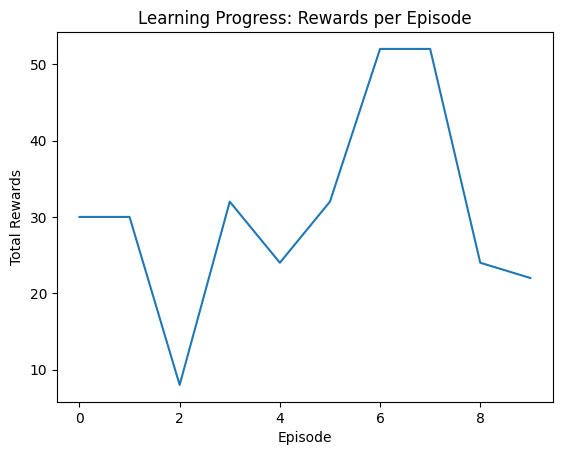

In [ ]:
################## PLOTTING ###########################
#######################################################
import matplotlib.pyplot as plt

def plot_learning_curve(total_rewards_per_episode):
    plt.plot(total_rewards_per_episode)
    plt.xlabel('Episode')
    plt.ylabel('Total Rewards')
    plt.title('Learning Progress: Rewards per Episode')
    plt.show()

# Example usage within the training loop
total_rewards_per_episode = []  # Initialize list to store rewards for each episode

for e in range(episodes):
    total_reward = 0  # Keep track of the reward per episode
    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(100):  # Limit steps per episode to 100
        action = agent.act(state)  # Agent takes action
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        agent.remember(state, action, reward, next_state, done)  # Remember the experience
        state = next_state

        total_reward += reward  # Accumulate reward

        if done:
            break

    total_rewards_per_episode.append(total_reward)  # Save reward for the episode

    # Train the agent using experience replay
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

# After training, plot the learning curve
plot_learning_curve(total_rewards_per_episode)




• Fluctuating rewards are normal in early RL training due to high exploration (epsilon-greedy policy)

• Small dataset (500 samples) limits the agent's exposure to diverse experiences, causing inconsistent learning

• Learning is occurring (peak at episode 6) but isn't smooth due to limited episodes (only 10) and data

• Performance drop near the end suggests possible over-exploration or generalization issues

• More episodes (hundreds/thousands) and larger dataset would help establish clearer learning trends

• Faster epsilon decay could help balance exploration-exploitation better

• Current results aren't incorrect, but need more data and training for smoother performance improvement

## Plotting the rest of the results


In [ ]:
# Initialize a list to store total rewards per episode
episode_rewards = []

# Inside the training loop (in the previous code)
for e in range(episodes):
    total_reward = 0  # Reset total reward for the episode

    state = env.reset()
    state = np.reshape(state, [1, state_size])

    for time in range(100):  # Limiting steps per episode
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, state_size])

        # Remember the experience
        agent.remember(state, action, reward, next_state, done)

        # Update total reward
        total_reward += reward

        state = next_state

        if done:
            break

    # Append total reward for this episode
    episode_rewards.append(total_reward)

    # Train the agent with experience replay
    if len(agent.memory) > batch_size:
        agent.replay(batch_size)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

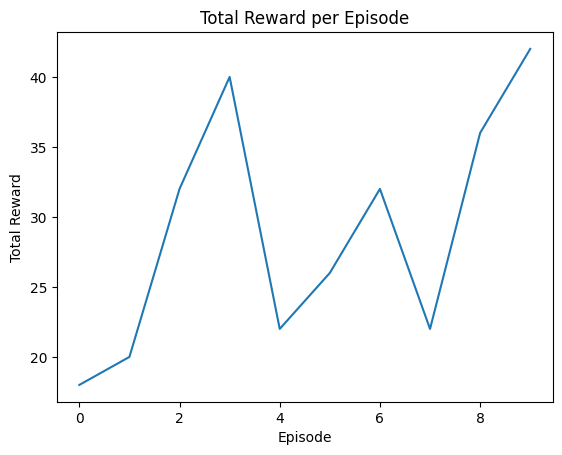

In [ ]:
################# Plotting the Rewards #################
########################################################

import matplotlib.pyplot as plt

# Plot episode rewards
plt.plot(episode_rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward per Episode')
plt.show()
